In [1]:
import sys
sys.path.append("../../Aorta3D/files2model/register/")
import main_register
import register_pair

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
import cv2
import numpy as np
from skimage.transform import resize, warp
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

# 1. Registration of clustered MSI images

In [3]:
msi_paths = ['/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML_1_upgma.png', '/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML_0_upgma.png', '/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML_4_upgma.png']

In [4]:
msi_images = [ cv2.imread(img_path) for img_path in msi_paths]
msi_images = [ cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in msi_images]
msi_images = [ np.asarray(img, dtype=np.float32) for img in msi_images]

In [5]:
def plot_images(images):
    plt.figure(figsize=(8, 6), dpi=80)
    for i in range(len(images)):
        plt.subplot(1,len(images),i+1)
        plt.imshow(images[i])

## Clustered input images:

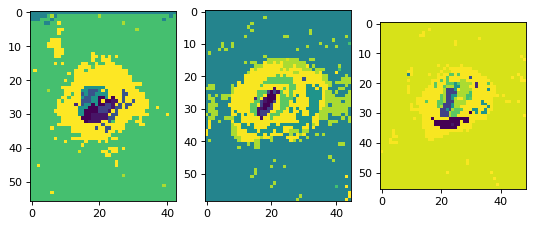

In [6]:
plot_images(msi_images)

## Masks used for future registration (pixels that touch the background cluster):

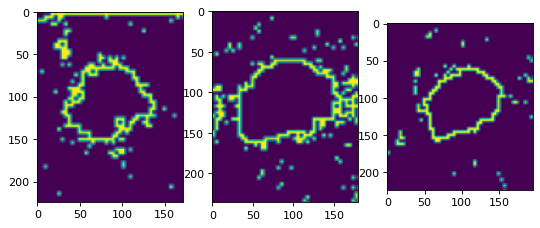

In [7]:
masks, segs = main_register.get_msi_masks(msi_images)
masks = [resize(m, (m.shape[0]*4, m.shape[1]*4)) for m in masks]
images = [resize(img, (img.shape[0]*4, img.shape[1]*4)) for img in segs]
images = [img.astype(int) for img in images]
plot_images(masks)

## Segmented images (same as masks but with added plaque regions):

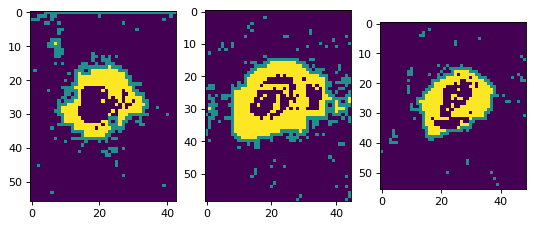

In [8]:
plot_images(segs)

## Detection of the most similar image in the set to make future registration more stable:

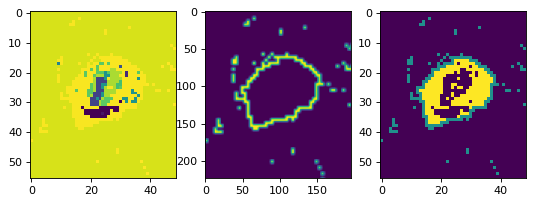

In [9]:
mostSimilar = main_register.getMostSimilar(masks)
plot_images([msi_images[mostSimilar], masks[mostSimilar], segs[mostSimilar]])

## Pairwise registration of each images to the most similar image (which stays unchanged):

(224, 196)
(224, 172)
(224, 196)
(236, 180)


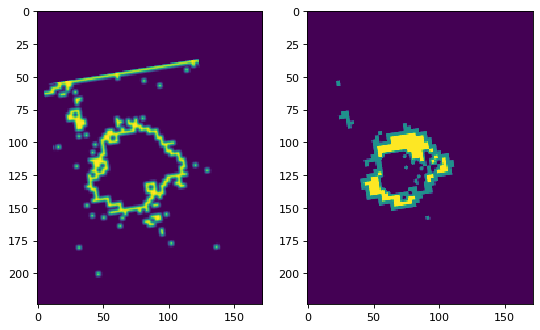

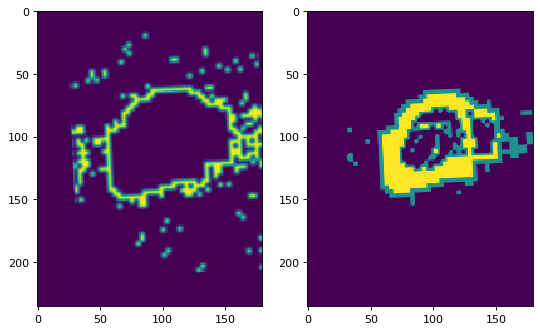

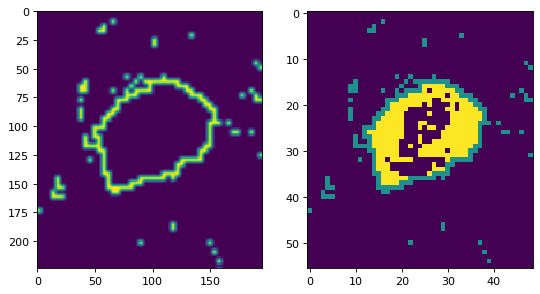

In [10]:
eval_diff = 0
for i in range(len(msi_images)):
    if i != mostSimilar:
        trans = register_pair.start_ransac(img1=rgb2gray(masks[mostSimilar]), img2=rgb2gray(masks[i]), brief=True, common_factor=1)
        reg_mask = warp(masks[i], np.linalg.inv(trans))

        eval_diff += main_register.difference(masks[mostSimilar], reg_mask)/masks[mostSimilar].size
        
        reg_image = warp(images[i], np.linalg.inv(trans), mode='constant', cval=0, preserve_range=True)
        #reg_image = np.nan_to_num(reg_image)
        reg_image = reg_image/np.max(reg_image)
        plot_images([reg_mask, reg_image])
    else:
        plot_images([masks[mostSimilar], segs[mostSimilar]])           

## The percentage of pixels that do not match the category with each other after the registration:

In [11]:
eval_diff

0.20522020836837288

# 2. Registration of clustered MSI images with given masks

In [12]:
msi_paths = ['/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML_1_upgma.png', '/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML_0_upgma.png', '/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML_4_upgma.png']

In [13]:
manual_masks_paths = ['/usr/local/hdd/rita/hiwi/Aorta3D/files2model/register/test/181114_AT1_Slide_D_Proteins.imzML_0_manual.png', '/usr/local/hdd/rita/hiwi/Aorta3D/files2model/register/test/181114_AT1_Slide_D_Proteins.imzML_1_manual.png', '/usr/local/hdd/rita/hiwi/Aorta3D/files2model/register/test/181114_AT1_Slide_D_Proteins.imzML_4_manual.png']

In [14]:
msi_paths = sorted(msi_paths)
images = [ cv2.imread(img_path) for img_path in msi_paths]
images = [ cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
images = [ np.asarray(img, dtype=np.float32) for img in images]

mask_paths = sorted(manual_masks_paths)
manual_masks = [ cv2.imread(path) for path in manual_masks_paths]
manual_masks = [ cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in manual_masks]
manual_masks = [ np.asarray(img, dtype=np.float32) for img in manual_masks]

_, segs = main_register.get_msi_masks(images)

#manual_masks = [resize(m, (m.shape[0]*4, m.shape[1]*4)) for m in manual_masks]

images = [resize(img, (img.shape[0]*4, img.shape[1]*4)) for img in segs]
images = [img.astype(int) for img in images]

In [15]:
manual_masks[0].shape

(236, 180)

In [16]:
images[0].shape

(236, 180)

## Manual masks for input images:

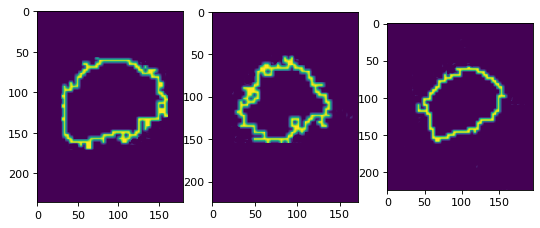

In [18]:
plot_images(manual_masks)

## Most similar image in the set to make future registration more stable:

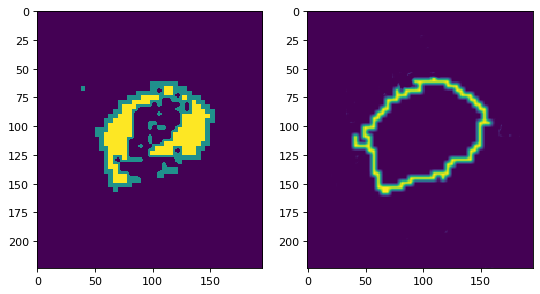

In [19]:
mostSimilar = main_register.getMostSimilar(manual_masks)
plot_images([images[mostSimilar], manual_masks[mostSimilar]])

## Pairwise registration of each images to the most similar image (which stays unchanged):

(224, 196)
(236, 180)
(224, 196)
(224, 172)


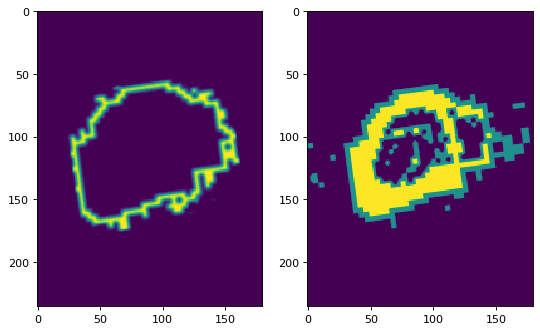

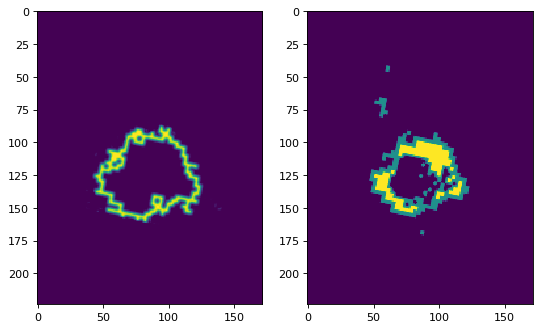

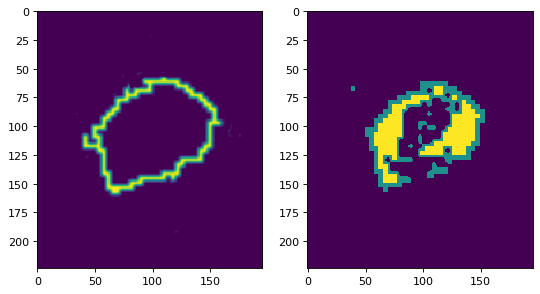

In [20]:
eval_diff = 0
for i in range(len(images)):
    if i != mostSimilar:
        trans = register_pair.start_ransac(img1=rgb2gray(manual_masks[mostSimilar]), img2=rgb2gray(manual_masks[i]), brief=True, common_factor=1)
        reg_mask = warp(manual_masks[i], np.linalg.inv(trans))

        eval_diff += main_register.difference(manual_masks[mostSimilar], reg_mask)/manual_masks[mostSimilar].size
        
        reg_image = warp(images[i], np.linalg.inv(trans), mode='constant', cval=0, preserve_range=True)
        #reg_image = np.nan_to_num(reg_image)
        reg_image = reg_image/np.max(reg_image)
        plot_images([reg_mask, reg_image])
    else:
        plot_images([manual_masks[mostSimilar], images[mostSimilar]])                   

# 3. Registration of microscopic images

In [22]:
micro_paths = ['/usr/local/hdd/rita/DL/sequence/ZT13_7-1.tif.small.tif', '/usr/local/hdd/rita/DL/sequence/ZT13_5-1.tif.small.tif', '/usr/local/hdd/rita/DL/sequence/ZT13_8-1.tif.small.tif']

In [23]:
import keras
from keras.optimizers import Adam
from keras import backend as K
from keras.models import model_from_json

def per_pixel_softmax_loss(y_true, y_pred):
    n_classes = 3
    y_true_f = K.reshape(y_true, (-1, n_classes))
    y_pred_f = K.reshape(y_pred, (-1, n_classes))
    return keras.losses.categorical_crossentropy(y_true_f, y_pred_f)

# load json and create model
json_file = open('/usr/local/hdd/rita/hiwi/Aorta3D/files2model/register/model_softmax_hist_640_ZT113.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/usr/local/hdd/rita/hiwi/Aorta3D/files2model/register/model_softmax_hist_ZT113.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
model.compile(optimizer=Adam(lr=1e-5), loss=per_pixel_softmax_loss, metrics=['accuracy'])
print("After loading model")

W0901 12:20:19.601295 140440015071040 deprecation_wrapper.py:119] From /home/rita/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Loaded model from disk
After loading model


In [24]:
images = [register_pair.predict_mask(model, p)[0] for p in micro_paths]
images = [img.reshape((img.shape[0], img.shape[1])) for img in images]
masks = [register_pair.predict_mask(model, p)[1] for p in micro_paths]

W0901 12:20:25.116647 140440015071040 deprecation_wrapper.py:119] From /home/rita/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



## Input images:

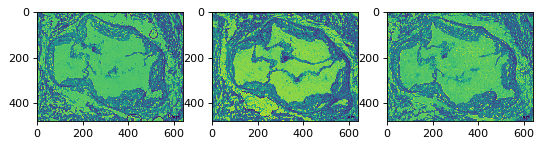

In [25]:
plot_images(images)

## Masks predicted with already trained model:

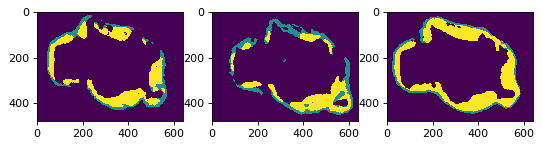

In [26]:
plot_images(masks)

## Most similar image in the set to make future registration more stable:

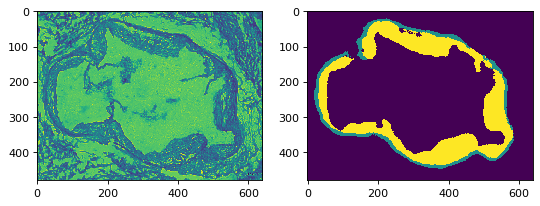

In [27]:
mostSimilar = main_register.getMostSimilar(masks)
plot_images([images[mostSimilar], masks[mostSimilar]])

## Pairwise registration of each images to the most similar image (which stays unchanged):

(240, 320)
(240, 320)
(240, 320)
(240, 320)


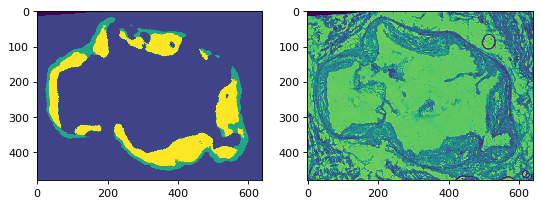

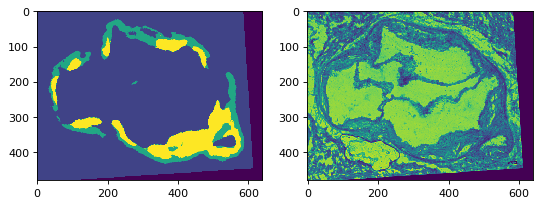

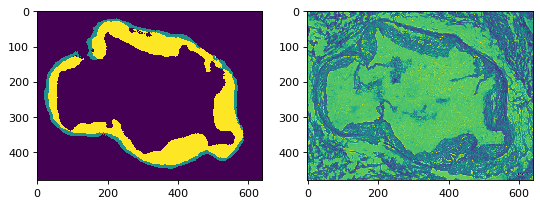

In [30]:
eval_diff = 0
for i in range(len(images)):
        if i != mostSimilar:
            trans = register_pair.start_ransac(img1=rgb2gray(masks[mostSimilar]), img2=rgb2gray(masks[i]), brief=True, common_factor=0.5)
            reg_mask = warp(masks[i], np.linalg.inv(trans))

            eval_diff += main_register.difference(masks[mostSimilar], reg_mask)/masks[mostSimilar].size

            rescale_trans = np.amin([ images[i].shape[0]/masks[i].shape[0], images[i].shape[1]/masks[i].shape[1] ])
            rescaled_transform = register_pair.rescale_transform_matrix(trans, rescale_trans)

            reg_image = warp(images[i], np.linalg.inv(rescaled_transform))
            plot_images([reg_mask, reg_image])
        else:
            plot_images([masks[mostSimilar], images[mostSimilar]]) 

In [32]:
!pwd

/usr/local/hdd/rita/hiwi/pyIMS/examples
